Today we will exlore Transformer based model BERT, and one of the most powerful technic in Deep Learning - Transfer Learning

# Part 1

In first part of lesson we will make context based representations from text using BERT. We can use first `[CLS]` token for this purpose.

As dataset we will use great parsed Lenta newspaper news for more then 10 years.

## Text clustering with BERT


Download this dataset

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2

And unzip it

In [ ]:
!bzip2 -d lenta-ru-news.csv.bz2

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
data = pd.read_csv('./lenta-ru-news.csv')
data.date = pd.to_datetime(data.date)

In [ ]:
data.sample(5)

Lets see, how many topics are there in dataset, and how they are distributed.

In [ ]:
data.topic.value_counts(normalize=True)

selecting data

We want to sort some data, because dataset is too big for processing it in-class.

#### Task 1

Select data, that correspond only for topic `Спорт`. After selecting it, reindex your new DataFrame.

In [ ]:
# YOUR CODE HERE
data = None

In [ ]:
assert data.shape[0] == 64413
assert data.shape[1] == 6

In [ ]:
data['text'].str.len().quantile(0.95)

Let's trim some of the longest news articles.

In [ ]:
data = data[(data['text'].str.len() > 20) & (data['text'].str.len() < 1798)]

And see it's length overall picture

In [ ]:
data['text'].str.len().describe()

In [ ]:
news_title = data['title']
news_text = data['text']

Now see how approximetly data is distributed after simliest tokenization

In [ ]:
splits = news_text.apply(lambda x: len(x.split()))

In [ ]:
splits.describe()

After exploring data we can now move to deal with transformers.

Using transformers library

Install libraries for tokenization and for uploading pre-trained models

In [ ]:
!pip install transformers > /dev/null
!pip install sentencepiece > /dev/null

Load predifined models. If we use pre-trained models, we also need tokenization, that was used while this big language model was trained.<br>
Load that tokenizer

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()

As ypu can see on picture below, for `[CLS]` token we need only 0-positioned tensor. THis picture is from transformers tutorial, that's why it has 2000 sentences in example, 66 positions in sentence and BERT output vector contain 768 length.

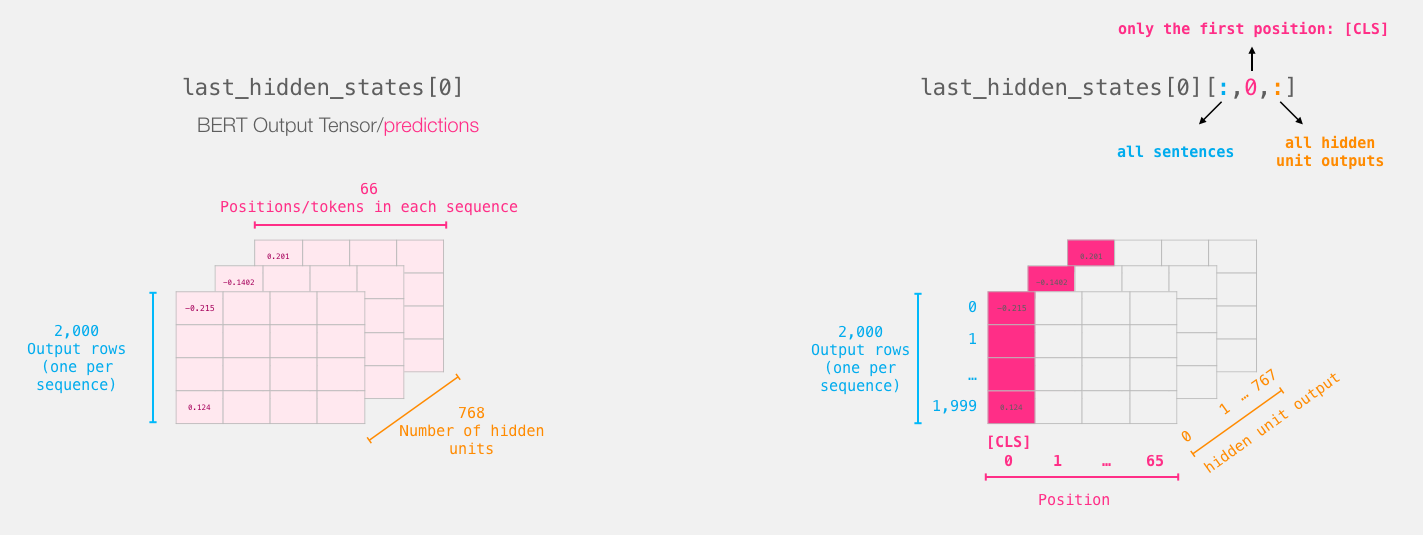

In [ ]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt') # use padding, truncation of long sequences and return pytorch tensors
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()}) # move all tensors on the same device as model
    embeddings = model_output.last_hidden_state[:, 0, :] # use only first [CLS] token vector
    embeddings = torch.nn.functional.normalize(embeddings) # normalize vector for easier convergence
    return embeddings[0].cpu().numpy() # return result as numpy vector

Let's see how this function works

In [ ]:
print(embed_bert_cls('привет мир', model, tokenizer).shape)

#### Task 2

Create numpy matrix x, that will contain on each row vector representation of every doc in `news_text` processed by `RuBERT-Tiny model`. 

In [ ]:
#YPUR CODE HERE
x = None

In [ ]:
((61182, 312), 0.579292353890196)

In [ ]:
assert x.shape[0] == 61182
assert x.shape[1] == 312
assert x[23].sum() > 0.57

Now we want to cluster our data and visualize it.<br>
For visualization we will use `UMAP` library, because it preserves the relative distances between components well while reducing the dimension.

In [ ]:
!pip install umap-learn

In [ ]:
import umap

# Prepare data for visualization
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(x)
result = pd.DataFrame(umap_data, columns=['x', 'y'])

#### Task 2

Choose any clustering method and make clusterization on our data. You can use of vector representation from BERT, or representation from UMAP. Also you can use method with predifined number of clusters, or method with no number of clusters parameter.

In [ ]:
cluster =  None

#### Task 3

Init clustering labels on your dataset

In [ ]:
result['labels'] = None
data['cluster'] = None

Let's combined clusters and outliers

In [ ]:
import matplotlib.pyplot as plt


# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Now we can plot interactive graphics of our data

In [ ]:
import random

choices = random.choices(data.index, k=200)
random_200_rows = data.iloc[choices, :]

In [ ]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

output_notebook()


p = figure(tools="pan,wheel_zoom,reset,save", title="UMAP representation of BERT vectors (sample 200 texts)")

source = ColumnDataSource(data=dict(x1=result.loc[choices, 'x'],
                                    x2=result.loc[choices, 'y'],
                                    names=random_200_rows.title.tolist()))

p.scatter(x="x1", y="x2", source=source, size=5)

words = LabelSet(x="x1", y="x2", text="names", source=source,
                y_offset=6, text_font_size="6pt",text_color="#555555", text_align="center")

p.add_layout(words)

show(p)

And if you want, you can plot wordcloud of trained clusters

In [ ]:
from wordcloud import WordCloud

In [ ]:
def draw_word_cloud(df, cluster_index, field):
  titles_aggregated = '\n'.join(df[df['cluster'] == cluster_index][field].str.lower().values)
  wordcloud = WordCloud().generate(titles_aggregated)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
draw_word_cloud(data, 14, 'title')

In [ ]:
 draw_word_cloud(data, 14, 'text')

# Part 2

In this task we will use mentioned above BERT model, and exlore well known comments from Odnoklassniki. We will solve multilabel classification problem on real problem, and use transfer learning technique.

Transfer Learning method is widely used when working with well known domain, or you have not so many data.

In [ ]:
!wget https://raw.githubusercontent.com/snv-ds/NLP_course/master/week2/train

In [ ]:
parse_labels = ['__label__NORMAL','__label__INSULT','__label__THREAT','__label__OBSCENITY']

In [ ]:
train = pd.read_csv('train', sep='\t', names=['id','target','temp1','temp2','comment'], index_col=0)

mask = train['comment'].isin(parse_labels) # to cope only with correct rows in data

train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask]['comment']
train.loc[mask,'comment'] = np.nan

for t in ['temp1','temp2']: # if comment have several labels of classes
    mask = train[t].isin(parse_labels)
    train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask][t]
    train.loc[mask,t] = np.nan
    train.loc[~train[t].isna(),'comment'] = train[~train[t].isna()][t]

train[['оскорбление','другое','непростойность','угроза']] = train['target'].str.get_dummies(sep=',')

train = train[['другое','оскорбление','непростойность','угроза', 'comment']]
train.sample(7)

In [ ]:
train = train.sample(70000)

## Using BERT as feature extractor

As in part 1, we will use vector representation of eac comment, that was processed by BERT. After getting vector of features we will train simple sklearn model.

In [ ]:
texts = train.comment

In [ ]:
x = np.zeros((len(texts), 312))
y = np.array(train[['другое',	'оскорбление',	'непростойность',	'угроза']])

In [ ]:
for ind, sent in enumerate(tqdm(texts)):
  x[ind] = embed_bert_cls(sent, model, tokenizer)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2029)

In [ ]:
y_train.shape, x_train.shape

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#### Task 4

Train any kind of model for our task, and make a prediction

In [ ]:
simple_model = None
y_pred = simple_model.predict(x_test)

In [ ]:
print(classification_report(y_pred, y_test, target_names=['другое', 'оскорбление', 'непростойность', 'угроза']))

## Using BERT as Embedder

In this task BERT model will be an Embeding-part of our big model. We will stack som layer over it and train only upper layer, freezing our Embedder.

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
bert = AutoModel.from_pretrained("cointegrated/rubert-tiny")
bert.cuda()

##### Task *

Count total number of parameters in our BERT.

In [ ]:
train = pd.read_csv('train', sep='\t', names=['id','target','temp1','temp2','comment'], index_col=0)

mask = train['comment'].isin(parse_labels) # to cope only with correct rows in data

train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask]['comment']
train.loc[mask,'comment'] = np.nan

for t in ['temp1','temp2']: # if comment have several labels of classes
    mask = train[t].isin(parse_labels)
    train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask][t]
    train.loc[mask,t] = np.nan
    train.loc[~train[t].isna(),'comment'] = train[~train[t].isna()][t]

train[['оскорбление','другое','непростойность','угроза']] = train['target'].str.get_dummies(sep=',')

train = train[['другое','оскорбление','непростойность','угроза', 'comment']]
train.sample(2)

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(train.comment,
                                                              train[['другое','оскорбление',
                                                                     'непростойность','угроза']],
                                                              test_size = 0.2,
                                                              random_state=2029)

Let's see how actually padding works. Explore all returned values.

In [ ]:
text = train_text[:2].tolist()
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)
# output
sent_id.keys()

We see that all comments are not so long, that's why in this task BERT can get great results.

In [ ]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
pd.Series(seq_len).quantile(0.965)

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
train_text.tolist(),
max_length = 50,
padding='max_length',
truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
val_text.tolist(),
max_length = 50,
padding='max_length',
truncation=True
)

In [ ]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values.tolist(), dtype=torch.float)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values.tolist(), dtype=torch.float)

Initialize all pytorch data variables

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data,
                            sampler = val_sampler,
                            batch_size=batch_size)

#### Task 5

Freeze all weights in `bert` model

In [ ]:
# YOUR CODE HERE

First let's make a simple model, that will stack only some extra linear layers over BERT-embedding

#### Task 6

Initialize linear layers correctly. Also set appropriate value for vector from BERT-embedder.

##### help

In [ ]:
# you need only [CLS]-token vector from BERT-embedder output. Because all other vectors corresponds to each word in document.

##### Continue working

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert, n_output):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)

      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = # YOUR CODE HERE

      # dense layer 2 (Output layer)
      self.fc2 = # YOUR CODE HERE

    #define the forward pass
    def forward(self, input_ids, attention_mask):

      #pass the inputs to the model  
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      last_hidden_state = # YOUR CODE HERE

      x = self.fc1(last_hidden_state)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      return x

In [ ]:
model = BERT_Arch(bert, 4).to(device)

##### Task *

Count number of parameters that we will learn, and total number of parameters.

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-5)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cross_entropy = torch.nn.functional.binary_cross_entropy_with_logits

# number of training epochs
epochs = 5

Let's check loss calculation

In [ ]:
batch = iter(train_dataloader).__next__()

text, mask, label = batch
pred = model(text.to(device), mask.to(device))

cross_entropy(pred.cpu(), label)

#### Task 7

As usual complete train function.

In [ ]:
# function to train the model
def train():
  
  # set model in train mode
  # YOUR CODE HERE

  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step, batch in enumerate(tqdm(train_dataloader)):

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    # YOUR CODE HERE

    # get model predictions for the current batch
    # YOUR CODE HERE

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    # YOUR CODE HERE

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    # YOUR CODE HERE

    # append the model predictions
    total_preds.append(preds.detach().cpu().numpy())

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss = 0
  
  # empty list to save the model predictions
  total_preds, total_labels = [], []
  # iterate over batches
  for step,batch in enumerate(tqdm(val_dataloader)):

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      total_preds.append(preds.detach().cpu().numpy())
      total_labels.append(labels.detach().cpu().numpy())

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels  = np.concatenate(total_labels, axis=0)
  
  # print evaluation metrics for our model
  print(classification_report(total_labels,
                              torch.sigmoid(torch.tensor(total_preds)).round(),
                              zero_division=True))

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

### Use more complex layer over BERT embedding

#### Task 8

Try to use GRU over BERT. Init GRU with `312` input_dim, `256` hidden_dim, `2` num_layers, `True` batch_first, and `0.1` dropout. After initialiation set correct `last_hidden_state` in forward pass. 

##### help

In [ ]:
# don't forget, that RNN deal with sequences. That's why it expect sequences of vectors for each word, that was got from BERT embedding.

##### Continue work

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert, n_output):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)

      self.rnn = # YOUR CODE HERE
        
      self.out = # YOUR CODE HERE
        
    #define the forward pass
    def forward(self, input_ids, attention_mask):

      #pass the inputs to the model  
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      last_hidden_state = # YOUR CODE HERE

      _, hidden = self.rnn(last_hidden_state)
        
      #hidden = [n layers * n directions, batch size, emb dim]
        
      hidden = self.dropout(hidden[-1,:,:])
                
      #hidden = [batch size, hid dim]
      
      output = self.out(hidden)
      
      #output = [batch size, out dim]
      
      return output

In [ ]:
model = BERT_Arch(bert, 4).to(device)
optimizer = AdamW(model.parameters(), lr = 1e-5)

##### Task *

Count number of parameters that we will learn, and total number of parameters.

In [ ]:
batch = iter(train_dataloader).__next__()

text, mask, label = batch
pred = model(text.to(device), mask.to(device))
# pred
cross_entropy(pred.cpu(), label)

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

# Futher steps to improve models.

You can add in your models:

1.   add text preprocessing
2.   text augmentation
3.   try more advanced layers over BERT (be careful, don't overfit on train)
4.   use ensemble of models

